<a href="https://colab.research.google.com/github/DanielaManate/SentimentAnalysis-TopicModeling/blob/master/SA1_Text_Normalization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing Libraries

In [1]:
!pip install contractions

     |████████████████████████████████| 245kB 3.8MB/s 
     |████████████████████████████████| 317kB 13.6MB/s 
  Created wheel for pyahocorasick: filename=pyahocorasick-1.4.0-cp36-cp36m-linux_x86_64.whl size=81714 sha256=9d966e09c71ed11f1a16ad5a17ba8a03c7fa9fb8ffc0d82cb29c976e1923c249
  Stored in directory: /root/.cache/pip/wheels/0a/90/61/87a55f5b459792fbb2b7ba6b31721b06ff5cf6bde541b40994
Successfully built pyahocorasick


In [2]:
import pandas as pd
import numpy as np

#regular expressions
import re

# for contractions (don't -> do not; can't -> can not)
import contractions

# natural language toolkit
import nltk 
# for stopwords (common words: to, that, this...)
nltk.download('stopwords')
from nltk.corpus import stopwords
# for word_tokenize (dividing the review(document) into words)
nltk.download('punkt')
from nltk.tokenize import word_tokenize

# spacy - advanced natural language processing
# for lemmatization
import spacy
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# plots
import matplotlib.pyplot as plt

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')
path = 'gdrive/My Drive/GH_NLP_Course/Data/'

# Reading Dataset & EDA (Exploratory Data Analysis)

The data source is a slice of the Yelp dataset (https://www.yelp.com/dataset). We will be looking at Yelp reviews and associated ratings for restaurants, from 2017, from the city of Glendale, AZ.

In [4]:
reviews = pd.read_csv(path + 'Input/1.input_data.csv')
reviews.head()

,rest_id,text,rating
0,yGMCl0vYigshkXiZFIDTNw,We arrived for our reservation at 7:15pm. The...,4.0
1,yGMCl0vYigshkXiZFIDTNw,BOGO....I find that when a server is inefficie...,3.0
2,yGMCl0vYigshkXiZFIDTNw,We received amazing service again. The food wa...,5.0
3,yGMCl0vYigshkXiZFIDTNw,Breakfast was delicious and waitress was aweso...,5.0
4,yGMCl0vYigshkXiZFIDTNw,"We have eaten here twice, for lunch. The first...",4.0


In [5]:
#Data Types
reviews.dtypes

rest_id     object
text        object
rating     float64
dtype: object

In [6]:
# Convert Rating to Integer
reviews['rating'] = reviews['rating'].astype(int)

In [7]:
# Look at first 10 rows
reviews.head(10)

,rest_id,text,rating
0,yGMCl0vYigshkXiZFIDTNw,We arrived for our reservation at 7:15pm. The...,4
1,yGMCl0vYigshkXiZFIDTNw,BOGO....I find that when a server is inefficie...,3
2,yGMCl0vYigshkXiZFIDTNw,We received amazing service again. The food wa...,5
3,yGMCl0vYigshkXiZFIDTNw,Breakfast was delicious and waitress was aweso...,5
4,yGMCl0vYigshkXiZFIDTNw,"We have eaten here twice, for lunch. The first...",4
5,yGMCl0vYigshkXiZFIDTNw,"awesome service, great food. Buffy was an ama...",5
6,yGMCl0vYigshkXiZFIDTNw,I love this establishment. Great service and f...,5
7,yGMCl0vYigshkXiZFIDTNw,"Great food, passed my expectations. Good coffe...",5
8,yGMCl0vYigshkXiZFIDTNw,What a great place for breakfast. Are at Mimi...,4
9,yGMCl0vYigshkXiZFIDTNw,I really like this place for breakfast and bru...,4


In [8]:
# Describe the data
reviews.describe()

,rating
count,10346.000000
mean,3.633482
std,1.562123
min,1.000000
25%,2.000000
50%,4.000000
75%,5.000000
max,5.000000


In [9]:
# Default: only numeric columns; 
# include = 'all' to see descriptions for all the columns
reviews.describe(include='all')

,rest_id,text,rating
count,10346,10346,10346.000000
unique,501,10323,NaN
top,ojGCRzEym2W3tSTo69fhxA,Absolutely the best Grinder I've ever had. Fre...,NaN
freq,201,2,NaN
mean,NaN,NaN,3.633482
std,NaN,NaN,1.562123
min,NaN,NaN,1.000000
25%,NaN,NaN,2.000000
50%,NaN,NaN,4.000000
75%,NaN,NaN,5.000000


In [10]:
# Duplicate review text exists

In [11]:
# Occurences of each rating
reviews['rating'].value_counts()

5    4772
1    1905
4    1754
3     981
2     934
Name: rating, dtype: int64

In [12]:
# Occurences of each rating, sorted ascending by rating
reviews['rating'].value_counts().sort_index()

1    1905
2     934
3     981
4    1754
5    4772
Name: rating, dtype: int64

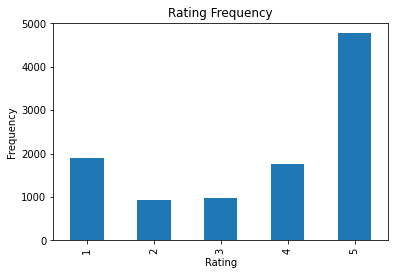

In [13]:
# Rating Frequency Graph

fig = reviews['rating'].value_counts().sort_index().plot(kind = 'bar')

fig.set_title('Rating Frequency')
fig.set_xlabel('Rating')
fig.set_ylabel('Frequency')

plt.show();

In [14]:
# Review Example

print(reviews.iloc[250,1])
print(reviews['text'].iloc[250])

Excellent food, fresh, with great flavor. Some Greek food places can feel a little divey, not this place. Modern and clean atmosphere, friendly staff, and delicious food. The Greek fries are my family's favorite. Sometimes we drop in during the middle of the day just to satisfy our craving for them! Highly recommended this place.
Excellent food, fresh, with great flavor. Some Greek food places can feel a little divey, not this place. Modern and clean atmosphere, friendly staff, and delicious food. The Greek fries are my family's favorite. Sometimes we drop in during the middle of the day just to satisfy our craving for them! Highly recommended this place.


In [15]:
# Review Example - all columns
reviews[250:251]

,rest_id,text,rating
250,Q8GBjqGjamI3b2ZaPQNa_Q,"Excellent food, fresh, with great flavor. Some...",5


In [16]:
# Length of the text of the review for Review Example
len(reviews['text'].iloc[250])

331

In [17]:
# Add text length as a separate column
reviews['char_count'] = reviews['text'].apply(len)
reviews.head()

,rest_id,text,rating,char_count
0,yGMCl0vYigshkXiZFIDTNw,We arrived for our reservation at 7:15pm. The...,4,302
1,yGMCl0vYigshkXiZFIDTNw,BOGO....I find that when a server is inefficie...,3,151
2,yGMCl0vYigshkXiZFIDTNw,We received amazing service again. The food wa...,5,111
3,yGMCl0vYigshkXiZFIDTNw,Breakfast was delicious and waitress was aweso...,5,146
4,yGMCl0vYigshkXiZFIDTNw,"We have eaten here twice, for lunch. The first...",4,710


In [18]:
# This returns length of df (no of rows)
print(len(reviews))
print(len(reviews['text']))

10346
10346


In [19]:
# What rows have a rating of 3
reviews['rating']==3

0        False
1         True
2        False
3        False
4        False
         ...  
10341    False
10342    False
10343    False
10344    False
10345    False
Name: rating, Length: 10346, dtype: bool

In [20]:
# Filter df to only the rows that have reviews with a rating of 3
reviews[reviews['rating']==3]

,rest_id,text,rating,char_count
1,yGMCl0vYigshkXiZFIDTNw,BOGO....I find that when a server is inefficie...,3,151
26,yGMCl0vYigshkXiZFIDTNw,The service was great. There was a 20 minute w...,3,348
39,thlAnPN1ApoNxSnok_fcvA,So we brought our kids here for breakfast befo...,3,459
53,thlAnPN1ApoNxSnok_fcvA,"While the food is good here, the entire place ...",3,127
61,thlAnPN1ApoNxSnok_fcvA,Food was pretty decent. But service was slow. ...,3,248
...,...,...,...,...
10303,oXIYs7rxT-bdgpeYzBfrzA,Meh! Shared the carambas nachos. What a sogg...,3,349
10306,oXIYs7rxT-bdgpeYzBfrzA,I have been going to this same Caramba for 20 ...,3,462
10323,F32Z-kI7ZJyGbjT8Vu3WOA,I am proud of my neighborhood Subway. I checke...,3,851
10329,WyeENX8AdrERdFZtVy7uzQ,Me and my husband have been here twice in 1 we...,3,463


In [21]:
# We are excluding 3 (neutral), because our objective is to 
# build a model that recognizes positive and negative reviews.

# 3 star reviews can contain both emotions. However, in normal 
# language, neutral language would mean no emotion.

# This is not applied in the case of reviews -> a 3 star
# review could mean users are content about some things
# and dissatisfied with others.

# Exclude reviews with 3 rating
reviews = reviews[reviews['rating']!=3]
reviews.head()

,rest_id,text,rating,char_count
0,yGMCl0vYigshkXiZFIDTNw,We arrived for our reservation at 7:15pm. The...,4,302
2,yGMCl0vYigshkXiZFIDTNw,We received amazing service again. The food wa...,5,111
3,yGMCl0vYigshkXiZFIDTNw,Breakfast was delicious and waitress was aweso...,5,146
4,yGMCl0vYigshkXiZFIDTNw,"We have eaten here twice, for lunch. The first...",4,710
5,yGMCl0vYigshkXiZFIDTNw,"awesome service, great food. Buffy was an ama...",5,59


In [22]:
# Reset index. Use the drop parameter to avoid the old index 
# being added as a column

reviews = reviews[reviews['rating']!=3].reset_index(drop=True)
reviews.head()

,rest_id,text,rating,char_count
0,yGMCl0vYigshkXiZFIDTNw,We arrived for our reservation at 7:15pm. The...,4,302
1,yGMCl0vYigshkXiZFIDTNw,We received amazing service again. The food wa...,5,111
2,yGMCl0vYigshkXiZFIDTNw,Breakfast was delicious and waitress was aweso...,5,146
3,yGMCl0vYigshkXiZFIDTNw,"We have eaten here twice, for lunch. The first...",4,710
4,yGMCl0vYigshkXiZFIDTNw,"awesome service, great food. Buffy was an ama...",5,59


In [23]:
# Add col 'positive' to show
# 1 if rating is 4 or 5  
# 0 if rating is 1 or 2

reviews['positive'] = np.where(reviews['rating'] > 3, 1, 0)
reviews.head()

,rest_id,text,rating,char_count,positive
0,yGMCl0vYigshkXiZFIDTNw,We arrived for our reservation at 7:15pm. The...,4,302,1
1,yGMCl0vYigshkXiZFIDTNw,We received amazing service again. The food wa...,5,111,1
2,yGMCl0vYigshkXiZFIDTNw,Breakfast was delicious and waitress was aweso...,5,146,1
3,yGMCl0vYigshkXiZFIDTNw,"We have eaten here twice, for lunch. The first...",4,710,1
4,yGMCl0vYigshkXiZFIDTNw,"awesome service, great food. Buffy was an ama...",5,59,1


### % Positive reviews


In [24]:
# Only positive reviews
reviews[reviews['positive']==1]

,rest_id,text,rating,char_count,positive
0,yGMCl0vYigshkXiZFIDTNw,We arrived for our reservation at 7:15pm. The...,4,302,1
1,yGMCl0vYigshkXiZFIDTNw,We received amazing service again. The food wa...,5,111,1
2,yGMCl0vYigshkXiZFIDTNw,Breakfast was delicious and waitress was aweso...,5,146,1
3,yGMCl0vYigshkXiZFIDTNw,"We have eaten here twice, for lunch. The first...",4,710,1
4,yGMCl0vYigshkXiZFIDTNw,"awesome service, great food. Buffy was an ama...",5,59,1
...,...,...,...,...,...
9359,8fBmyHKbrqCDLD9at83EgQ,Probably the best Salsitas in the valley. The ...,5,182,1
9361,8fBmyHKbrqCDLD9at83EgQ,Again blows everyone outa the water best Calif...,5,119,1
9362,8fBmyHKbrqCDLD9at83EgQ,I am in college and love coming to this place....,5,157,1
9363,8fBmyHKbrqCDLD9at83EgQ,This place offers some of the best tacos. Alwa...,5,488,1


In [25]:
# No of positive reviews
len(reviews[reviews['positive']==1])

6526

In [26]:
# No of total reviews
len(reviews)

9365

In [27]:
# Percent
len(reviews[reviews['positive']==1])/len(reviews)

0.6968499733048585

In [28]:
# Alternative (because positive has 0 or 1 as values)
np.mean(reviews['positive'])
# Alternative 2
# reviews['positive'].mean()

0.6968499733048585

### What is a list?

In [29]:
list1 = [1, 2, 3]
list1

[1, 2, 3]

In [30]:
list2 = [1, 5, 6]
list2

[1, 5, 6]

In [31]:
# Show all elements in list1 that are not in list2
[no for no in list1 if no not in list2]

[2, 3]

# Text Normalization

In [32]:
reviews['text'].iloc[250]

"The third time I've been here. Dropped from 5 stars to 2. I guess when they were new to this spot they cared about service. Waiting for food is a joke!! Doubt I'll come back now, third time wasn't a charm."

In [33]:
def preprocess_text(document):
    # Replace contractions (don't -> do not). Using contractions library
    document = contractions.fix(document)
    
    # # Lowercasing
    document = document.lower()
    
    # # Remove punctuation using regex
    # ^ = NOT
    # \w = word character
    # \s = whitespace character
    # Replace what is not a word and not a whitespace with ' '
    document = re.sub(r'[^\w\s]',' ', document)
    
    # # Remove Special Characters & Numbers
    document = re.sub(r'[^a-z ]', '', document)

    # # Tokenization
    document = word_tokenize(document)
    
    # # Remove StopWords
    stop_words = stopwords.words('english')
    document = [word for word in document if word not in stop_words]
    
    # Change Output from List to Sentence
    document = ' '.join(document)
    
    # # Lemmatization
    document = [word.lemma_ for word in nlp(document)]
    
    # Change Output from List to Sentence
    document = ' '.join(document)
    
    return document

In [34]:
final_corpus_test = [preprocess_text(document) 
                for document in reviews['text'][0:300].to_list()]

In [35]:
final_corpus_test[250]

'third time drop star guess new spot care service wait food joke doubt come back third time charm'

In [36]:
# Implementing on entire dataset
final_corpus = [preprocess_text(document) 
                for document in reviews['text'].to_list()]

In [37]:
reviews['text_prep'] = final_corpus

In [38]:
reviews.head()

,rest_id,text,rating,char_count,positive,text_prep
0,yGMCl0vYigshkXiZFIDTNw,We arrived for our reservation at 7:15pm. The...,4,302,1,arrived reservation pm seat -PRON- right time ...
1,yGMCl0vYigshkXiZFIDTNw,We received amazing service again. The food wa...,5,111,1,receive amazing service food cook right waitre...
2,yGMCl0vYigshkXiZFIDTNw,Breakfast was delicious and waitress was aweso...,5,146,1,breakfast delicious waitress awesome steak egg...
3,yGMCl0vYigshkXiZFIDTNw,"We have eaten here twice, for lunch. The first...",4,710,1,eaten twice lunch first time french dip mom fi...
4,yGMCl0vYigshkXiZFIDTNw,"awesome service, great food. Buffy was an ama...",5,59,1,awesome service great food buffy amazing server


In [39]:
reviews.iloc[250][['text', 'text_prep']].to_dict()

{'text': "The third time I've been here. Dropped from 5 stars to 2. I guess when they were new to this spot they cared about service. Waiting for food is a joke!! Doubt I'll come back now, third time wasn't a charm.",
 'text_prep': 'third time drop star guess new spot care service wait food joke doubt come back third time charm'}

# Exporting to csv

In [40]:
reviews.to_csv(path + 'Input/2.input_data_prepped.csv',
               index = False)